In [79]:
import pandas as pd
import ast
import numpy as np
import sklearn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
import xgboost as xgb

In [80]:
pd.set_option('display.max_columns', None)

In [81]:
import numpy as np

def haversine_vectorized(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance in kilometers between two points
    (specified in decimal degrees) on the earth.
    
    This is a vectorized implementation using NumPy.
    
    Parameters:
    lat1, lon1: NumPy arrays of latitudes and longitudes for the first set of points.
    lat2, lon2: NumPy arrays (or single values) for the second set of points.
    
    Returns:
    A NumPy array containing the distances in kilometers.
    """
    # Mean Earth radius in kilometers
    R = 6371.0
    
    # Convert decimal degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    # Haversine formula
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    distance_km = R * c
    return distance_km

In [82]:
def safe_convert_to_list(x):
    if pd.isna(x):
        return np.nan # Keep NaN as NaN
    try:
        # This safely evaluates the string as a Python literal (a list)
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        # If it's not a valid list string (e.g., 'not a list')
        return np.nan # Treat bad data as missing

In [83]:
df = pd.read_csv('mazowieckie-09-03-2025-output.csv', encoding ='utf-8')

/tmp/ipykernel_3904/3381626737.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('mazowieckie-09-03-2025-output.csv', encoding ='utf-8')


In [84]:
df = df[df['city'] == 'warszawa']
df.reset_index(inplace=True)

In [85]:
df.offerType.unique()

array(['sprzedaz'], dtype=object)

In [86]:
df.location_district.unique()

array(['Białołęka', 'Włochy', 'Wilanów', 'Targówek', 'Chrzanów',
       'Odolany', 'Ursus', 'Mokotów', 'Ursynów', 'Bielany',
       'Praga-Północ', 'Sadyba', 'Wawer', 'Wola', 'Śródmieście',
       'Dolny Mokotów', 'Gołąbki', 'Saska Kępa', 'Śródmieście Południowe',
       'Ochota', 'Unknown District', 'Skorosze', 'Muranów', 'Gocław',
       'Bródno', 'Stegny', 'Sielce', 'Targówek Mieszkaniowy', 'Bemowo',
       'Żoliborz', 'Praga', 'Stary Rembertów', 'Natolin', 'Służewiec',
       'Chomiczówka', 'Stara Ochota', 'Górny Mokotów', 'Praga-Południe',
       'Mirów', 'Rembertów', 'Potok', 'Tarchomin', 'Rakowiec', 'Falenica',
       'Powiśle', 'Wrzeciono', 'Wesoła', 'Czerniaków', 'Wierzbno',
       'Stary Żoliborz', 'Wyględów', 'Stokłosy', 'Stara Miłosna',
       'Witolin', 'Centrum', 'Nowodwory', 'Siekierki', 'Imielin',
       'Nowe Włochy', 'Brzeziny', 'Nowa Praga', 'Nowe Bródno', 'Żerań',
       'Anin', 'Sady Żoliborskie', 'Służew', 'Stare Włochy', 'Zawady',
       'Młynów', 'Czyste', 'Okęc

In [87]:
df.head()

,index,id,price,market,advertiserType,advertType,source,createdAt,modifiedAt,description,title,slug,exclusiveOffer,externalId,features,creationSource,openDay,referenceId,area,area_range,buildYear,buildingFloorsNumber,buildingMaterial,buildingOwnership,buildingType,city,city_id,constructionStatus,country,energyCertificate,equipmentTypes,extrasTypes,floorNumber,heating,marketType,mediaTypes,obidoAdvert,offerType,photo,priceRange,pricePerM,propertyType,province,regularUser,rent,roomsNum,securityTypes,subregion,windowsType,categoryId,env,hidePrice,sellerId,userType,extras,media,ownership,url,status,categoryName,totalRooms,properType,floor,location_latitude,location_longitude,location_district,location_city,location_province,location_street,owner_id,owner_name,owner_phone,agency_id,agency_name,agency_license,agency_phones
0,0,66348331.0,NaN,PRIMARY,business,DEVELOPER_UNIT,urn:partner:obidointegration,2025-01-14T13:54:48+01:00,2025-03-09T11:54:03+01:00,3-pokojowe mieszkanie numer B/71 na parterze ...,My1wb2tvam93ZSBtaWVzemthbmllIDY3bTIgKyBvZ3LDs2...,3-pokojowe-mieszkanie-67m2-ogrodek-bezposredni...,False,674c1de9-9343-4518-ae28-4afef8d3b714,"['garaż/miejsce parkingowe', 'taras', 'ogródek...",api,NaN,NaN,67.02,[],2026.0,5.0,NaN,full_ownership,NaN,warszawa,26.0,to_completion,Polska,NaN,NaN,"[""garage"", ""terrace"", ""garden"", ""lift""]",ground_floor,NaN,primary,NaN,y,sprzedaz,aHR0cHM6Ly9pcmVsYW5kLmFwb2xsby5vbHhjZG4uY29tL3...,NaN,NaN,mieszkanie,mazowieckie,n,NaN,3,NaN,powiat-warszawa,NaN,101.0,production,1.0,10556429.0,developer,[],[],full_ownership,https://www.otodom.pl/pl/oferta/3-pokojowe-mie...,active,Mieszkania,NaN,NaN,NaN,52.319740,20.995624,Białołęka,Warszawa,mazowieckie,ul. Marywilska,10556429.0,Marta Bogusz,+48786790038,10556429.0,Unidevelopment,NaN,['+48222989898']
1,1,65998767.0,2300000.0,SECONDARY,business,AGENCY,urn:partner:esticrm,2024-10-11T14:09:03+02:00,2025-03-08T11:30:24+01:00,WYJĄTKOWY APARTAMENT W WYSOKIM STANDARDZIE | 1...,V3lqxIV0a293eSBBcGFydGFtZW50IHwgJnF1b3Q7WmllbG...,wyjatkowy-apartament-zielona-italia-ID4sWif,False,9ddce9d2-b7eb-465f-b417-29d0a1edf204,"['internet', 'telewizja kablowa', 'drzwi / okn...",api,NaN,RANDALL622980,116.00,[],2014.0,5.0,NaN,full_ownership,NaN,warszawa,26.0,ready_to_use,Polska,NaN,furniture,"[""lift"", ""balcony"", ""air_conditioning"", ""garag...",floor_4,NaN,secondary,"[""internet"", ""cable-television""]",n,sprzedaz,aHR0cHM6Ly9pcmVsYW5kLmFwb2xsby5vbHhjZG4uY29tL3...,1000001-3000000,19828.0,mieszkanie,mazowieckie,n,NaN,3,"[""anti_burglary_door"", ""entryphone"", ""closed_a...",powiat-warszawa,NaN,101.0,production,0.0,9330344.0,agency,[],[],full_ownership,https://www.otodom.pl/pl/oferta/wyjatkowy-apar...,active,Квартира,NaN,NaN,NaN,52.206120,20.893280,Włochy,Warszawa,mazowieckie,ul. Obywatelska,9330344.0,Dawid Trójczak,+48793403506,9330344.0,Randall Home,28798,"['+48459412278', '+48793403506']"
2,2,66568645.0,1295000.0,PRIMARY,business,AGENCY,urn:site:local,2025-03-08T19:05:23+01:00,2025-03-08T20:50:51+01:00,Kupujący nie płaci prowizji ! Bez podatku PCC ...,T2themphIGNlbm93YSFCZXogUGNjLGJleiBwcm93aXpqaS...,okazja-cenowa-bez-pcc-bez-prowizji-72-67m2-wil...,False,31542/3150/OMS,"['telewizja kablowa', 'internet', 'telefon', '...",import,NaN,NaN,72.67,[],2025.0,4.0,NaN,full_ownership,NaN,warszawa,26.0,to_completion,Polska,NaN,NaN,"[""balcony"", ""garage"", ""lift""]",floor_2,NaN,primary,"[""cable-television"", ""internet"", ""phone""]",n,sprzedaz,aHR0cHM6Ly9pcmVsYW5kLmFwb2xsby5vbHhjZG4uY29tL3...,1000001-3000000,17820.0,mieszkanie,mazowieckie,n,NaN,3,monitoring,powiat-warszawa,NaN,101.0,production,0.0,4923604.0,agency,[],[],full_ownership,https://www.otodom.pl/pl/oferta/okazja-cenowa-...,active,Mieszkania,NaN,NaN,NaN,52.155283,21.084311,Wilanów,Warszawa,mazowieckie,Jerzego Holzera,4923604.0,Małgorzata Wojciechowska,+48790554616,4923604.0,AS Immobilia sp. z o.o.,NaN,['+48883050750']
3,4,66510987.0,609000.0,SECONDARY,private,PRIVATE,urn:site:local,2025-02-21T15:54:34+01:00,2025-03-08T15:57

In [88]:
features_and_target = [
    # --- Target variable
    'price',
    # --- Group 1: Numerical Features
    'area',
    'buildYear',
    'buildingFloorsNumber',
    'floorNumber',
    'roomsNum',
    'location_latitude',
    'location_longitude',

    # --- Group 2: Categorical Features (Need Encoding) ---
    # We need to encode them (e.g., One-Hot, Target, or Label Encoding).
    'market',
    'buildingMaterial',
    'constructionStatus',
    'ownership',
    'userType',
    'location_district',
    
    # --- Group 3: List/Text Features (Need Engineering) ---
    # These are your highest-potential features.
    # DO NOT feed them directly to XGBoost.
    # You must parse them to create new 0/1 columns (e.g., 'has_balcony', 'has_elevator').
    'features'
]

In [89]:
df = df[features_and_target]

In [90]:
# Warsaw city center coordinates to calculate distance from center
WARSAW_CENTER_LAT = 52.2286
WARSAW_CENTER_LON = 21.0031

In [91]:
df['distance_from_center'] = haversine_vectorized(df['location_latitude'], df['location_longitude'], WARSAW_CENTER_LAT, WARSAW_CENTER_LON)

In [92]:
df['features'] = df['features'].apply(safe_convert_to_list)

Features columns has many features of property. We should take the most important of them (features_to_engineer).
After that we should use multi-label binarization technique, since one property has many features. We will encode all the important features as 0/1 columns using **MultiLabelBinarizer**

In [93]:
df['features'].explode().unique()

array(['garaż/miejsce parkingowe', 'taras', 'ogródek', 'winda',
       'internet', 'telewizja kablowa', 'drzwi / okna antywłamaniowe',
       'domofon / wideofon', 'teren zamknięty', 'monitoring / ochrona',
       'meble', 'balkon', 'klimatyzacja', 'pom. użytkowe', 'telefon',
       'piwnica', 'oddzielna kuchnia', 'system alarmowy', 'piekarnik',
       'lodówka', 'pralka', 'telewizor', 'zmywarka', 'kuchenka',
       'rolety antywłamaniowe', 'dwupoziomowe', nan], dtype=object)

In [94]:
features_to_engineer = [
    'taras',
    'ogródek',
    'winda',
    'balkon',
    'klimatyzacja',
    'pom. użytkowe',
    'piwnica',
    'dwupoziomowe',
    'garaż/miejsce parkingowe',
    'oddzielna kuchnia',
    'teren zamknięty'
]

In [95]:
mlb = MultiLabelBinarizer()

In [96]:
encoded_df = pd.DataFrame(mlb.fit_transform(df['features']), columns=mlb.classes_, index=df.index)

In [97]:
encoded_df = encoded_df[features_to_engineer]

In [98]:
df_final = pd.concat([df, encoded_df], axis=1)

In [99]:
df_final = df_final.drop(columns=['features'])

Now lets fix the values of floorNumber column

In [100]:
df_final.floorNumber.unique()

array(['ground_floor', 'floor_4', 'floor_2', 'floor_5', 'floor_6',
       'floor_3', 'floor_1', 'floor_8', 'floor_higher_10', 'floor_10',
       'floor_7', nan, 'floor_9', 'cellar', 'garret'], dtype=object)

In [101]:
df_final.buildingFloorsNumber.unique()

array([5.000e+00, 4.000e+00, 9.000e+00, 3.000e+00, 8.000e+00, 6.000e+00,
       7.000e+00, 2.000e+00, 2.500e+01, 4.400e+01, 1.000e+01,       nan,
       1.100e+01, 1.000e+00, 1.400e+01, 1.500e+01, 2.400e+01, 2.900e+01,
       1.600e+01, 1.300e+01, 1.200e+01, 1.700e+01, 2.700e+01, 3.000e+01,
       2.800e+01, 1.900e+01, 2.200e+01, 2.000e+01, 1.800e+01, 2.300e+01,
       5.200e+01, 2.600e+01, 4.200e+01, 5.100e+01, 5.400e+01, 1.967e+03])

In [102]:
floor_map = {
    'cellar': -1,
    'ground_floor': 0,
    'floor_1': 1,
    'floor_2': 2,
    'floor_3': 3,
    'floor_4': 4,
    'floor_5': 5,
    'floor_6': 6,
    'floor_7': 7,
    'floor_8': 8,
    'floor_9': 9,
    'floor_10': 10,
    'floor_higher_10': 11  # Using 11 to maintain the order (it's > 10)
}

In [103]:
df_final.head()

,price,area,buildYear,buildingFloorsNumber,floorNumber,roomsNum,location_latitude,location_longitude,market,buildingMaterial,constructionStatus,ownership,userType,location_district,distance_from_center,taras,ogródek,winda,balkon,klimatyzacja,pom. użytkowe,piwnica,dwupoziomowe,garaż/miejsce parkingowe,oddzielna kuchnia,teren zamknięty
0,NaN,67.02,2026.0,5.0,ground_floor,3,52.319740,20.995624,PRIMARY,NaN,to_completion,full_ownership,developer,Białołęka,10.147018,1,1,1,0,0,0,0,0,1,0,0
1,2300000.0,116.00,2014.0,5.0,floor_4,3,52.206120,20.893280,SECONDARY,NaN,ready_to_use,full_ownership,agency,Włochy,7.888081,1,0,1,1,1,1,0,0,1,0,1
2,1295000.0,72.67,2025.0,4.0,floor_2,3,52.155283,21.084311,PRIMARY,NaN,to_completion,full_ownership,agency,Wilanów,9.854286,0,0,1,1,0,0,0,0,1,0,0
3,609000.0,45.90,1979.0,9.0,floor_4,2,52.277879,21.054928,SECONDARY,NaN,ready_to_use,limited_ownership,private,Targówek,6.517061,0,0,1,1,1,0,1,0,0,1,0
4,999000.0,63.51,2027.0,3.0,floor_2,3,52.218240,20.891190,PRIMARY,brick,to_completion,full_ownership,agency,Chrzanów,7.709440,0,0,1,1,1,1,1,0,1,0,0


In [104]:
df_final['floor_numeric'] = df_final['floorNumber'].map(floor_map)

In [105]:
df_final = df_final.drop(columns=['floorNumber'])

In [106]:
df_final.head()

,price,area,buildYear,buildingFloorsNumber,roomsNum,location_latitude,location_longitude,market,buildingMaterial,constructionStatus,ownership,userType,location_district,distance_from_center,taras,ogródek,winda,balkon,klimatyzacja,pom. użytkowe,piwnica,dwupoziomowe,garaż/miejsce parkingowe,oddzielna kuchnia,teren zamknięty,floor_numeric
0,NaN,67.02,2026.0,5.0,3,52.319740,20.995624,PRIMARY,NaN,to_completion,full_ownership,developer,Białołęka,10.147018,1,1,1,0,0,0,0,0,1,0,0,0.0
1,2300000.0,116.00,2014.0,5.0,3,52.206120,20.893280,SECONDARY,NaN,ready_to_use,full_ownership,agency,Włochy,7.888081,1,0,1,1,1,1,0,0,1,0,1,4.0
2,1295000.0,72.67,2025.0,4.0,3,52.155283,21.084311,PRIMARY,NaN,to_completion,full_ownership,agency,Wilanów,9.854286,0,0,1,1,0,0,0,0,1,0,0,2.0
3,609000.0,45.90,1979.0,9.0,2,52.277879,21.054928,SECONDARY,NaN,ready_to_use,limited_ownership,private,Targówek,6.517061,0,0,1,1,1,0,1,0,0,1,0,4.0
4,999000.0,63.51,2027.0,3.0,3,52.218240,20.891190,PRIMARY,brick,to_completion,full_ownership,agency,Chrzanów,7.709440,0,0,1,1,1,1,1,0,1,0,0,2.0


In [107]:
df_final['floor_numeric'] = df_final['floor_numeric'].astype('float64')

In [108]:
df_final.head()

,price,area,buildYear,buildingFloorsNumber,roomsNum,location_latitude,location_longitude,market,buildingMaterial,constructionStatus,ownership,userType,location_district,distance_from_center,taras,ogródek,winda,balkon,klimatyzacja,pom. użytkowe,piwnica,dwupoziomowe,garaż/miejsce parkingowe,oddzielna kuchnia,teren zamknięty,floor_numeric
0,NaN,67.02,2026.0,5.0,3,52.319740,20.995624,PRIMARY,NaN,to_completion,full_ownership,developer,Białołęka,10.147018,1,1,1,0,0,0,0,0,1,0,0,0.0
1,2300000.0,116.00,2014.0,5.0,3,52.206120,20.893280,SECONDARY,NaN,ready_to_use,full_ownership,agency,Włochy,7.888081,1,0,1,1,1,1,0,0,1,0,1,4.0
2,1295000.0,72.67,2025.0,4.0,3,52.155283,21.084311,PRIMARY,NaN,to_completion,full_ownership,agency,Wilanów,9.854286,0,0,1,1,0,0,0,0,1,0,0,2.0
3,609000.0,45.90,1979.0,9.0,2,52.277879,21.054928,SECONDARY,NaN,ready_to_use,limited_ownership,private,Targówek,6.517061,0,0,1,1,1,0,1,0,0,1,0,4.0
4,999000.0,63.51,2027.0,3.0,3,52.218240,20.891190,PRIMARY,brick,to_completion,full_ownership,agency,Chrzanów,7.709440,0,0,1,1,1,1,1,0,1,0,0,2.0


In [109]:
median_floor = df_final['floor_numeric'].median(skipna=True)
median_floor

np.float64(2.0)

In [110]:
df_final['floor_numeric'] = df_final['floor_numeric'].fillna(median_floor)

In [111]:
df_final = df_final.dropna(subset=['price']).reset_index(drop=True)

In [112]:
df_final.dtypes

price                       float64
area                        float64
buildYear                   float64
buildingFloorsNumber        float64
roomsNum                     object
location_latitude           float64
location_longitude          float64
market                       object
buildingMaterial             object
constructionStatus           object
ownership                    object
userType                     object
location_district            object
distance_from_center        float64
taras                         int64
ogródek                       int64
winda                         int64
balkon                        int64
klimatyzacja                  int64
pom. użytkowe                 int64
piwnica                       int64
dwupoziomowe                  int64
garaż/miejsce parkingowe      int64
oddzielna kuchnia             int64
teren zamknięty               int64
floor_numeric               float64
dtype: object

In [113]:
df_final['buildingMaterial'].unique()
df_final['constructionStatus'].unique()
df_final['userType'].unique()
df_final['roomsNum'].unique()

array(['3', '2', '4', '1', '5', '6', '7', 'more', '8', '9', '10'],
      dtype=object)

In [114]:
df_final['roomsNum'] = df_final['roomsNum'].replace('more', 11)

In [115]:
df_final['roomsNum'] = pd.to_numeric(df_final['roomsNum'], errors='coerce')

In [116]:
# 1. Define the logical order
# We assign numbers based on value. 'nan' can be a neutral 0.
status_map = {
    'to_renovation': -1,  # Lowest value
    'to_completion': 0,   # Neutral/Primary market
    'ready_to_use': 1,    # Highest value
    np.nan: 0             # Assign 'nan' to the neutral category
}

# 2. Map the values and fill any that were missed (just in case)
df_final['constructionStatus_numeric'] = df_final['constructionStatus'].map(status_map)
df_final['constructionStatus_numeric'].fillna(0, inplace=True)

# 3. Drop the original column
df_final = df_final.drop('constructionStatus', axis=1)

/tmp/ipykernel_3904/1616183813.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['constructionStatus_numeric'].fillna(0, inplace=True)


3. The High-Cardinality Column: location_district
Your location_district column is also an object and likely has many unique values (e.g., 20+ districts).

Bad Method: One-Hot Encoding (pd.get_dummies) would create 20+ new columns, which is inefficient.

Best Method: Target Encoding.

Target Encoding is a powerful technique that replaces the district's name with a number. The number it uses is the average price for that district. This is an extremely strong signal for your model.

The easiest way to do this is with the category_encoders library.

In [117]:
# 1. List the columns you want to encode
columns_to_onehot = ['market', 'buildingMaterial', 'userType', 'ownership']

# 2. Use pd.get_dummies
# dummy_na=True is a great trick! It will create a new column 
# like 'buildingMaterial_nan', which is a very strong signal.
df_final = pd.get_dummies(
    df_final, 
    columns=columns_to_onehot, 
    dummy_na=True,  # Creates a column for 'nan' values
    drop_first=False  # Keeps all categories
)

In [118]:
df_final.head()

,price,area,buildYear,buildingFloorsNumber,roomsNum,location_latitude,location_longitude,location_district,distance_from_center,taras,ogródek,winda,balkon,klimatyzacja,pom. użytkowe,piwnica,dwupoziomowe,garaż/miejsce parkingowe,oddzielna kuchnia,teren zamknięty,floor_numeric,constructionStatus_numeric,market_PRIMARY,market_SECONDARY,market_nan,buildingMaterial_breezeblock,buildingMaterial_brick,buildingMaterial_cellular_concrete,buildingMaterial_concrete,buildingMaterial_concrete_plate,buildingMaterial_hydroton,buildingMaterial_other,buildingMaterial_reinforced_concrete,buildingMaterial_silikat,buildingMaterial_wood,buildingMaterial_nan,userType_agency,userType_developer,userType_private,userType_nan,ownership_full_ownership,ownership_limited_ownership,ownership_share,ownership_usufruct,ownership_nan
0,2300000.0,116.00,2014.0,5.0,3,52.206120,20.893280,Włochy,7.888081,1,0,1,1,1,1,0,0,1,0,1,4.0,1,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False
1,1295000.0,72.67,2025.0,4.0,3,52.155283,21.084311,Wilanów,9.854286,0,0,1,1,0,0,0,0,1,0,0,2.0,0,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False
2,609000.0,45.90,1979.0,9.0,2,52.277879,21.054928,Targówek,6.517061,0,0,1,1,1,0,1,0,0,1,0,4.0,1,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False
3,999000.0,63.51,2027.0,3.0,3,52.218240,20.891190,Chrzanów,7.709440,0,0,1,1,1,1,1,0,1,0,0,2.0,0,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
4,1190000.0,52.00,2018.0,8.0,3,52.221110,20.930600,Odolany,5.008006,0,0,0,0,0,1,0,0,1,0,0,5.0,1,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True


In [119]:
df_final.dtypes

price                                   float64
area                                    float64
buildYear                               float64
buildingFloorsNumber                    float64
roomsNum                                  int64
location_latitude                       float64
location_longitude                      float64
location_district                        object
distance_from_center                    float64
taras                                     int64
ogródek                                   int64
winda                                     int64
balkon                                    int64
klimatyzacja                              int64
pom. użytkowe                             int64
piwnica                                   int64
dwupoziomowe                              int64
garaż/miejsce parkingowe                  int64
oddzielna kuchnia                         int64
teren zamknięty                           int64
floor_numeric                           

In [120]:
median_year = df_final['buildYear'].median(skipna=True)
median_year

np.float64(2008.0)

In [121]:
df_final['buildYear'] = df_final['buildYear'].fillna(median_year)

In [122]:
median_building_floors_number = df_final['buildingFloorsNumber'].median(skipna=True)
median_building_floors_number

np.float64(5.0)

In [123]:
df_final['buildingFloorsNumber'] = df_final['buildingFloorsNumber'].fillna(median_building_floors_number)

In [124]:
# check missing values
for col in df_final.columns:
    result = []
    result.append(f"Missing values in {col}: {df_final[col].isna().sum()}")
    print(result)

['Missing values in price: 0']
['Missing values in area: 0']
['Missing values in buildYear: 0']
['Missing values in buildingFloorsNumber: 0']
['Missing values in roomsNum: 0']
['Missing values in location_latitude: 0']
['Missing values in location_longitude: 0']
['Missing values in location_district: 0']
['Missing values in distance_from_center: 0']
['Missing values in taras: 0']
['Missing values in ogródek: 0']
['Missing values in winda: 0']
['Missing values in balkon: 0']
['Missing values in klimatyzacja: 0']
['Missing values in pom. użytkowe: 0']
['Missing values in piwnica: 0']
['Missing values in dwupoziomowe: 0']
['Missing values in garaż/miejsce parkingowe: 0']
['Missing values in oddzielna kuchnia: 0']
['Missing values in teren zamknięty: 0']
['Missing values in floor_numeric: 0']
['Missing values in constructionStatus_numeric: 0']
['Missing values in market_PRIMARY: 0']
['Missing values in market_SECONDARY: 0']
['Missing values in market_nan: 0']
['Missing values in buildingMa

In [125]:
import category_encoders as ce
from sklearn.model_selection import train_test_split

In [126]:
df_full_train, df_test = train_test_split(df_final, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [127]:
y_train = df_train['price'].reset_index(drop=True)
y_val = df_val['price'].reset_index(drop=True)
y_test = df_test['price'].reset_index(drop=True)

In [128]:
X_train = df_train.reset_index(drop=True)
X_val = df_val.reset_index(drop=True)
X_test = df_test.reset_index(drop=True)

In [129]:
del df_train['price']
del df_val['price']
del df_test['price']

### Method Note: Handling High-Cardinality Features (District)

**Why TargetEncoder instead of One-Hot (DictVectorizer)?**

1.  **The Cardinality Problem:** `location_district` has many unique values (high cardinality). One-Hot Encoding would create a new column for every district, resulting in a wide, sparse matrix that dilutes the signal.
2.  **How TargetEncoder Works:** It replaces the category name (e.g., "Mokotów") with the average target value (mean price) for that category. It keeps the feature in **one single column**.
3.  **XGBoost Efficiency:** Instead of needing 20+ branches to ask "Is it Mokotów?", "Is it Wola?", the tree can make one powerful split based on value (e.g., `district_value > 600k`), instantly separating expensive areas from cheaper ones.
4.  **CRITICAL:** To prevent **Data Leakage**, we must split the data into Train/Test *before* fitting the TargetEncoder. The encoder must only learn average prices from the Training set.

In [130]:
# We use handle_unknown='value' and handle_missing='value'
# This handles cases where a district in the val/test set 
# was not seen in the train set.
encoder = ce.TargetEncoder(
    cols=['location_district'],
    handle_unknown='value',
    handle_missing='value'
)

In [131]:
# Fit the encoder ONLY on the training data
encoder.fit(X_train, y_train)

,verbose,0
,cols,['location_district']
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,min_samples_leaf,20
,smoothing,10
,hierarchy,None


In [132]:
X_train_encoded = encoder.transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

In [133]:
X_train_encoded

,price,area,buildYear,buildingFloorsNumber,roomsNum,location_latitude,location_longitude,location_district,distance_from_center,taras,ogródek,winda,balkon,klimatyzacja,pom. użytkowe,piwnica,dwupoziomowe,garaż/miejsce parkingowe,oddzielna kuchnia,teren zamknięty,floor_numeric,constructionStatus_numeric,market_PRIMARY,market_SECONDARY,market_nan,buildingMaterial_breezeblock,buildingMaterial_brick,buildingMaterial_cellular_concrete,buildingMaterial_concrete,buildingMaterial_concrete_plate,buildingMaterial_hydroton,buildingMaterial_other,buildingMaterial_reinforced_concrete,buildingMaterial_silikat,buildingMaterial_wood,buildingMaterial_nan,userType_agency,userType_developer,userType_private,userType_nan,ownership_full_ownership,ownership_limited_ownership,ownership_share,ownership_usufruct,ownership_nan
0,4100000.0,136.80,2008.0,5.0,4,52.224769,21.031220,2.151094e+06,1.962089,0,0,1,0,0,0,1,0,1,0,0,0.0,0,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True
1,900000.0,53.00,1967.0,4.0,2,52.194510,20.894210,7.465223e+05,8.331435,0,0,0,0,0,0,0,0,0,1,0,3.0,1,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False
2,690000.0,32.30,2019.0,6.0,1,52.172619,20.996647,1.509018e+06,6.240310,0,0,0,0,0,0,0,0,0,0,0,0.0,1,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False
3,765000.0,53.10,1972.0,4.0,3,52.183631,21.050011,1.509018e+06,5.934836,0,0,0,1,1,0,1,0,0,0,0,3.0,1,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True
4,630000.0,46.45,1935.0,3.0,2,52.211202,20.920720,1.001126e+06,5.935936,0,0,0,1,0,0,1,0,0,1,0,2.0,0,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8560,699000.0,41.00,2008.0,10.0,2,52.266730,20.961000,1.355085e+06,5.117726,0,0,1,1,0,1,0,0,0,1,0,8.0,1,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False
8561,960000.0,59.25,1990.0,4.0,3,52.203873,21.004687,1.509018e+06,2.751632,0,0,0,1,0,0,1,0,0,1,0,4.0,-1,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True
8562,1014900.0,59.70,2026.0,8.0,4,52.203575,20.877511,7.465223e+05,8.997175,0,0,1,1,0,1,0,0,1,0,0,7.0,0,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False
8563,1599000.0,98.79,2007.0,9.0,6,52.230109,20.960766,1.242819e+06,2.888154,0,0,1,0,0,0,0,0,1,1,0,1.0,1,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False


In [134]:
feature_names = encoder.get_feature_names_out()
feature_names

array(['price', 'area', 'buildYear', 'buildingFloorsNumber', 'roomsNum',
       'location_latitude', 'location_longitude', 'location_district',
       'distance_from_center', 'taras', 'ogródek', 'winda', 'balkon',
       'klimatyzacja', 'pom. użytkowe', 'piwnica', 'dwupoziomowe',
       'garaż/miejsce parkingowe', 'oddzielna kuchnia', 'teren zamknięty',
       'floor_numeric', 'constructionStatus_numeric', 'market_PRIMARY',
       'market_SECONDARY', 'market_nan', 'buildingMaterial_breezeblock',
       'buildingMaterial_brick', 'buildingMaterial_cellular_concrete',
       'buildingMaterial_concrete', 'buildingMaterial_concrete_plate',
       'buildingMaterial_hydroton', 'buildingMaterial_other',
       'buildingMaterial_reinforced_concrete', 'buildingMaterial_silikat',
       'buildingMaterial_wood', 'buildingMaterial_nan', 'userType_agency',
       'userType_developer', 'userType_private', 'userType_nan',
       'ownership_full_ownership', 'ownership_limited_ownership',
       'owners

In [135]:
f_names_list = feature_names.tolist()

In [136]:
dtrain = xgb.DMatrix(X_train_encoded, label=y_train, feature_names=f_names_list)
dval = xgb.DMatrix(X_val_encoded, label=y_val, feature_names=f_names_list)

In [137]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [138]:
xgb_params = {
    'eta' : 0.1,
    'max_depth': 6,
    'min_child_weight' : 1,
    
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

In [139]:
model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200,
                  verbose_eval = 5,
                  evals=watchlist)

[0]	train-rmse:970588.46849	val-rmse:903021.77156
[5]	train-rmse:597718.84099	val-rmse:537373.89800
[10]	train-rmse:375551.25518	val-rmse:337738.56759
[15]	train-rmse:240502.89328	val-rmse:225018.28078
[20]	train-rmse:157693.97384	val-rmse:170046.77464
[25]	train-rmse:105261.42156	val-rmse:146641.93618
[30]	train-rmse:72197.26526	val-rmse:135434.03204
[35]	train-rmse:50928.51876	val-rmse:131734.77402
[40]	train-rmse:37418.31355	val-rmse:129761.18673
[45]	train-rmse:29687.46986	val-rmse:130169.71090
[50]	train-rmse:24550.82604	val-rmse:130273.25810
[55]	train-rmse:21041.84420	val-rmse:130691.04017
[60]	train-rmse:18538.69791	val-rmse:131010.85643
[65]	train-rmse:16728.11290	val-rmse:131192.92232
[70]	train-rmse:15673.22680	val-rmse:131526.27110
[75]	train-rmse:14871.08445	val-rmse:131748.64250
[80]	train-rmse:14301.97176	val-rmse:131826.33096
[85]	train-rmse:13813.17406	val-rmse:131726.68336
[90]	train-rmse:13190.95795	val-rmse:131661.11127
[95]	train-rmse:12471.75655	val-rmse:131680.09

In [140]:
df.price.max()

np.float64(20000000.0)

In [141]:
df.price.min()

np.float64(6800.0)

### First results

**Why results are bad and what we can do?**

1.  **The model is Overfitting: Filter Extreme Outliers** `price` has values min = 6800 zl which is unrealistic and 20,000,000 zl which is probably some ultra luxury appartments. Lets remove the top 1% and bottom 1% of prices.
2.  **Use Log Transformation, good for price models:** It replaces the category name (e.g., "Mokotów") with the average target value (mean price) for that category. It keeps the feature in **one single column**.
3.  **Tune Parameters to fight Overfitting:**: Gap between train and validation (110k vs 460k) means the model is too complex.

In [142]:
df_final_cleaned = df_final.copy()

In [143]:
low = df_final_cleaned['price'].quantile(0.01)
high = df_final_cleaned['price'].quantile(0.965)
(low, high)
# Values are quite reasonable: on market we rarely see flats below 400k, for Warsaw is even 500k.
# As well as 5M flats are quite rare. We can even take 3M, lets remove 3%+ the most expensive.

(np.float64(417000.0), np.float64(3150000.0))

In [144]:
df_final_cleaned = df_final_cleaned[(df_final_cleaned['price']>low) & (df_final_cleaned['price']<high)]

In [156]:
df_final_cleaned.reset_index(drop=True)

,price,area,buildYear,buildingFloorsNumber,roomsNum,location_latitude,location_longitude,location_district,distance_from_center,taras,ogródek,winda,balkon,klimatyzacja,pom. użytkowe,piwnica,dwupoziomowe,garaż/miejsce parkingowe,oddzielna kuchnia,teren zamknięty,floor_numeric,constructionStatus_numeric,market_PRIMARY,market_SECONDARY,market_nan,buildingMaterial_breezeblock,buildingMaterial_brick,buildingMaterial_cellular_concrete,buildingMaterial_concrete,buildingMaterial_concrete_plate,buildingMaterial_hydroton,buildingMaterial_other,buildingMaterial_reinforced_concrete,buildingMaterial_silikat,buildingMaterial_wood,buildingMaterial_nan,userType_agency,userType_developer,userType_private,userType_nan,ownership_full_ownership,ownership_limited_ownership,ownership_share,ownership_usufruct,ownership_nan,price_log
0,2300000.0,116.00,2014.0,5.0,3,52.206120,20.893280,Włochy,7.888081,1,0,1,1,1,1,0,0,1,0,1,4.0,1,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False,14.648420
1,1295000.0,72.67,2025.0,4.0,3,52.155283,21.084311,Wilanów,9.854286,0,0,1,1,0,0,0,0,1,0,0,2.0,0,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False,14.074022
2,609000.0,45.90,1979.0,9.0,2,52.277879,21.054928,Targówek,6.517061,0,0,1,1,1,0,1,0,0,1,0,4.0,1,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,13.319575
3,999000.0,63.51,2027.0,3.0,3,52.218240,20.891190,Chrzanów,7.709440,0,0,1,1,1,1,1,0,1,0,0,2.0,0,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,13.814511
4,1190000.0,52.00,2018.0,8.0,3,52.221110,20.930600,Odolany,5.008006,0,0,0,0,0,1,0,0,1,0,0,5.0,1,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,13.989465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13625,1699999.0,81.00,2013.0,11.0,3,52.178010,20.996466,Mokotów,5.643535,0,0,1,1,0,0,0,0,0,0,0,10.0,1,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,14.346139
13626,564900.0,35.00,2024.0,2.0,2,52.346034,21.050510,Białołęka,13.450353,0,1,1,0,0,0,0,0,1,0,0,0.0,1,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,13.244406
13627,920000.0,62.00,1992.0,3.0,3,52.194167,21.051981,Mokotów,5.074655,0,1,0,1,0,0,1,0,1,1,1,0.0,1,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,13.732130
13628,1155000.0,51.40,2005.0,3.0,2,52.208245,20.958248,Ochota,3.802494,0,0,1,1,1,0,1,0,1,0,1,1.0,1,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False,13.959612


In [157]:
df_final_cleaned['price_log'] = np.log1p(df_final_cleaned['price'])

In [158]:
# 1. Split the raw dataframe
df_full_train, df_test = train_test_split(df_final_cleaned, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [160]:
# 2. Create y (Target) - Reset index ensures it starts at 0, 1, 2...
y_train = df_train['price_log'].reset_index(drop=True)
y_val = df_val['price_log'].reset_index(drop=True)
y_test = df_test['price_log'].reset_index(drop=True)

In [166]:
# 3. Create X (Features) - Drop target columns FIRST, then reset index
# We drop both 'price' (raw) and 'price_log' (target) to be safe
cols_to_drop = ['price', 'price_log']

In [167]:
X_train = df_train.drop(columns=cols_to_drop).reset_index(drop=True)
X_val = df_val.drop(columns=cols_to_drop).reset_index(drop=True)
X_test = df_test.drop(columns=cols_to_drop).reset_index(drop=True)

In [148]:
encoder = ce.TargetEncoder(cols=['location_district'], handle_unknown='value', handle_missing='value')

In [149]:
encoder.fit(X_train, y_train)

,verbose,0
,cols,['location_district']
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,min_samples_leaf,20
,smoothing,10
,hierarchy,None


In [150]:
X_train_encoded = encoder.transform(X_train)
X_val_encoded = encoder.transform(X_val)

In [173]:
X_val_encoded

,area,buildYear,buildingFloorsNumber,roomsNum,location_latitude,location_longitude,location_district,distance_from_center,taras,ogródek,winda,balkon,klimatyzacja,pom. użytkowe,piwnica,dwupoziomowe,garaż/miejsce parkingowe,oddzielna kuchnia,teren zamknięty,floor_numeric,constructionStatus_numeric,market_PRIMARY,market_SECONDARY,market_nan,buildingMaterial_breezeblock,buildingMaterial_brick,buildingMaterial_cellular_concrete,buildingMaterial_concrete,buildingMaterial_concrete_plate,buildingMaterial_hydroton,buildingMaterial_other,buildingMaterial_reinforced_concrete,buildingMaterial_silikat,buildingMaterial_wood,buildingMaterial_nan,userType_agency,userType_developer,userType_private,userType_nan,ownership_full_ownership,ownership_limited_ownership,ownership_share,ownership_usufruct,ownership_nan
0,31.57,1972.0,10.0,1,52.174659,21.013713,13.940095,6.041416,0,0,1,1,0,0,0,0,0,1,0,8.0,1,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False
1,50.10,2006.0,3.0,3,52.306257,21.060639,13.454836,9.481275,0,0,1,1,1,0,0,0,1,0,1,3.0,1,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False
2,60.40,2026.0,8.0,4,52.204415,20.880565,13.507425,8.770363,0,0,1,1,0,0,1,0,1,0,0,2.0,0,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
3,42.64,2025.0,9.0,1,52.229141,21.000470,13.823158,0.188992,0,0,1,0,0,1,0,0,1,0,1,2.0,0,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False
4,48.00,1970.0,10.0,3,52.191959,20.991054,13.909666,4.156169,0,0,1,1,0,0,1,0,1,0,0,2.0,1,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2721,116.82,2026.0,3.0,5,52.221775,21.243677,13.637299,16.404104,0,0,1,1,0,1,0,1,1,0,0,3.0,0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False
2722,38.00,2008.0,10.0,2,52.282380,21.065370,13.536197,7.329824,0,0,1,1,0,0,1,0,0,1,0,9.0,1,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True
2723,86.00,1999.0,16.0,3,52.223200,20.984650,13.810095,1.392758,0,0,1,1,0,0,0,0,1,0,0,11.0,0,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
2724,26.17,2025.0,7.0,1,52.260429,21.039000,13.634253,4.301249,0,0,1,0,0,0,0,0,0,0,0,0.0,0,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False


In [152]:
y_val

0       13.248116
1       13.527830
2       13.554147
3       14.181100
4       13.586099
          ...    
2721    14.202087
2722    13.287880
2723    14.253766
2724    13.005585
2725    13.383190
Name: price_log, Length: 2726, dtype: float64

In [178]:
current_feature_names = X_train_encoded.columns.tolist()

In [179]:
dtrain = xgb.DMatrix(X_train_encoded, label=y_train, feature_names=current_feature_names)
dval = xgb.DMatrix(X_val_encoded, label=y_val, feature_names=current_feature_names)

In [180]:
# With 'min_child_weight': 5 [999] train-rmse:0.06343 val-rmse:0.11993
# With 'min_child_weight': 10 [999]	train-rmse:0.06815	val-rmse:0.12010

xgb_params = {
    'eta': 0.05,              # Lower learning rate (makes learning slower but more robust)
    'max_depth': 5,           # Shallower trees
    'min_child_weight': 5,    # Conservative: needs 5 samples to make a split
    'subsample': 0.8,         # Randomness to prevent overfitting
    'colsample_bytree': 0.8,  # Randomness to prevent overfitting
    
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

# Since eta is lower (0.05), we need more rounds
model = xgb.train(
    xgb_params, 
    dtrain, 
    num_boost_round=1000,         # Increase rounds
    evals=watchlist,
    verbose_eval=50
)

[0]	train-rmse:0.40236	val-rmse:0.39589
[50]	train-rmse:0.14082	val-rmse:0.15745
[100]	train-rmse:0.11719	val-rmse:0.13927
[150]	train-rmse:0.10827	val-rmse:0.13374
[200]	train-rmse:0.10256	val-rmse:0.13068
[250]	train-rmse:0.09797	val-rmse:0.12834
[300]	train-rmse:0.09378	val-rmse:0.12629
[350]	train-rmse:0.09034	val-rmse:0.12517
[400]	train-rmse:0.08706	val-rmse:0.12403
[450]	train-rmse:0.08435	val-rmse:0.12317
[500]	train-rmse:0.08162	val-rmse:0.12251
[550]	train-rmse:0.07912	val-rmse:0.12182
[600]	train-rmse:0.07678	val-rmse:0.12131
[650]	train-rmse:0.07462	val-rmse:0.12092
[700]	train-rmse:0.07253	val-rmse:0.12050
[750]	train-rmse:0.07064	val-rmse:0.12034
[800]	train-rmse:0.06872	val-rmse:0.12003
[850]	train-rmse:0.06704	val-rmse:0.11980
[900]	train-rmse:0.06538	val-rmse:0.11969
[950]	train-rmse:0.06362	val-rmse:0.11952
[999]	train-rmse:0.06212	val-rmse:0.11942


In [184]:
y_pred_log = model.predict(dval)

In [196]:
predicted_price = np.expm1(y_pred_log).astype(float)
actual_price = np.expm1(y_val)

In [197]:
df_results = pd.DataFrame({
    'Actual_Price': actual_price,
    'Predicted_Fair_Value': predicted_price,
    'Difference': predicted_price - actual_price,
    'Error_Pct': (predicted_price - actual_price) / actual_price * 100
})

In [200]:
df_results.round(0).astype(int)

,Actual_Price,Predicted_Fair_Value,Difference,Error_Pct
0,567000,596779,29779,5
1,750000,742387,-7613,-1
2,770000,775895,5895,1
3,1441362,1411481,-29881,-2
4,795000,804492,9492,1
...,...,...,...,...
2721,1471932,1453820,-18112,-1
2722,590000,569166,-20835,-4
2723,1550000,1858482,308482,20
2724,444890,459210,14320,3


In [186]:
rmse = np.sqrt(mean_squared_error(actual_price, predicted_price))

In [187]:
rmse

np.float64(160451.44751644932)

In [188]:
print(f"Final Validation RMSE: {rmse:,.0f} PLN")

Final Validation RMSE: 160,451 PLN


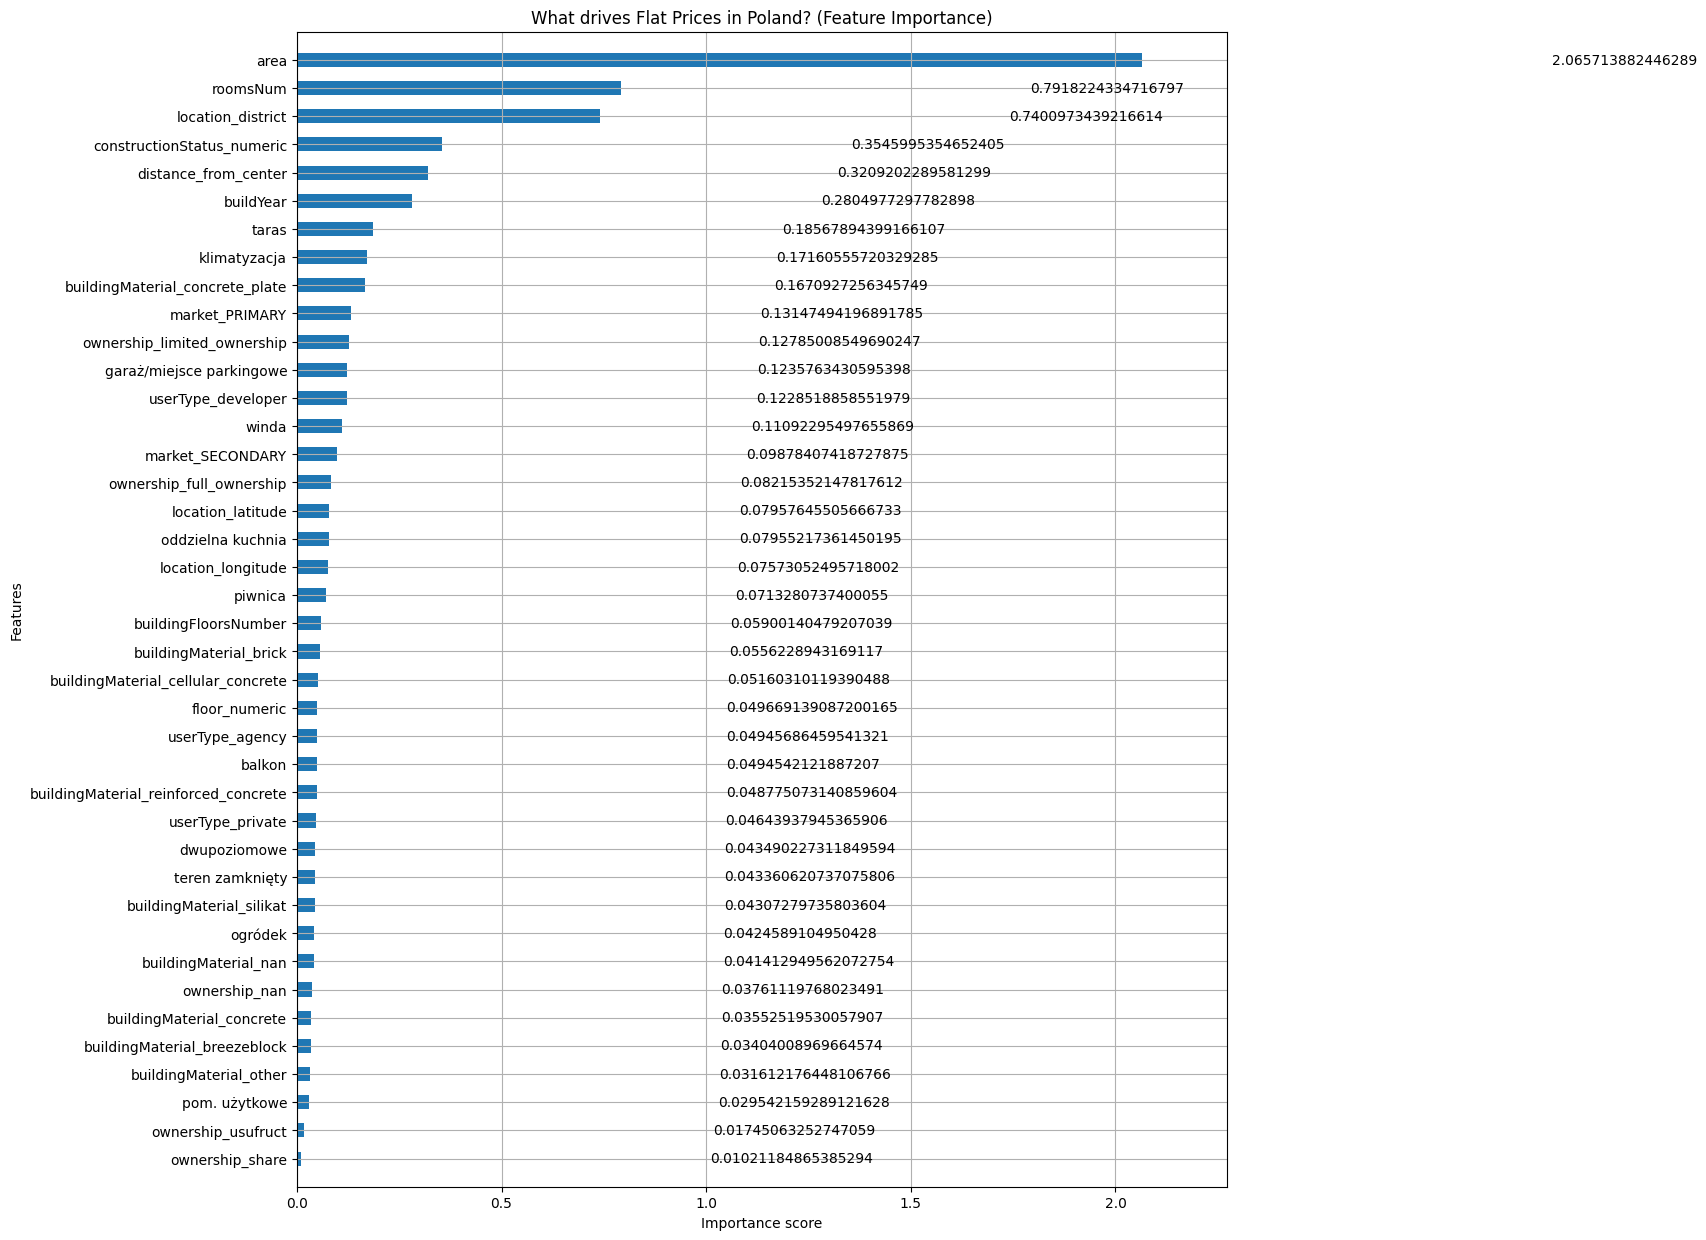

In [189]:
import matplotlib.pyplot as plt

# Create a nice plot
fig, ax = plt.subplots(figsize=(12, 15))
xgb.plot_importance(model, ax=ax, height=0.5, importance_type='gain')
plt.title("What drives Flat Prices in Poland? (Feature Importance)")
plt.show()

In [190]:
diff = np.abs(predicted_price - actual_price)

print(f"Mean Absolute Error (MAE): {diff.mean():,.0f} PLN")
print(f"Median Absolute Error:     {diff.median():,.0f} PLN")

Mean Absolute Error (MAE): 93,325 PLN
Median Absolute Error:     50,143 PLN


The fact that the Mean (93k) is nearly double the Median (50k) confirms that your distribution of errors is heavily skewed.

Your model is accurately predicting the price of a 400k-1M PLN flat (Error ≈ 50k).

However, it struggles immensely with the 2M-5M PLN luxury flats, where an error of 500k-1M PLN in a few rows pulls the average MAE up for the entire dataset.

In [201]:
# Assuming you still have 'df_results' from the previous step 
# (Actual_Price, Predicted_Fair_Value, Difference, Error_Pct)

# Calculate the ABSOLUTE error in PLN
df_results['Abs_Error'] = np.abs(df_results['Difference'])

# Find the rows with the highest errors (e.g., top 0.5% or top 100 flats)
worst_hits = df_results.sort_values(by='Abs_Error', ascending=False).head(100)

print("Top 5 types of flats where the model fails:")
print(worst_hits['Actual_Price'].describe())

Top 5 types of flats where the model fails:
count    1.000000e+02
mean     2.045255e+06
std      6.848053e+05
min      4.973640e+05
25%      1.497500e+06
50%      2.115000e+06
75%      2.610000e+06
max      3.034233e+06
Name: Actual_Price, dtype: float64


In [209]:
worst_hits.Actual_Price.mean()

np.float64(2045254.5500000003)

In [210]:
worst_hits

,Actual_Price,Predicted_Fair_Value,Difference,Error_Pct,Abs_Error
2345,3000000.0,1.636137e+06,-1.363863e+06,-45.462113,1.363863e+06
2243,2500000.0,1.166111e+06,-1.333889e+06,-53.355555,1.333889e+06
81,2800000.0,1.534145e+06,-1.265855e+06,-45.209103,1.265855e+06
801,2700000.0,1.576992e+06,-1.123008e+06,-41.592889,1.123008e+06
570,2740000.0,1.642428e+06,-1.097573e+06,-40.057391,1.097573e+06
...,...,...,...,...,...
2450,2600000.0,2.216771e+06,-3.832287e+05,-14.739567,3.832287e+05
1645,1333000.0,1.714243e+06,3.812429e+05,28.600366,3.812429e+05
227,1490000.0,1.869525e+06,3.795250e+05,25.471477,3.795250e+05
1727,1450000.0,1.070940e+06,-3.790598e+05,-26.142052,3.790598e+05


In [212]:
# Define the target range (0.5M to 1.5M PLN)
MIN_PRICE = 500000
MAX_PRICE = 1500000

# Ensure y_val_pln and preds_pln are defined (from np.expm1(y_val) and np.expm1(preds_log))

# 1. Create a filter mask based on the ACTUAL price (y_val_pln)
# We only evaluate the model where the true price falls within our core market definition.
filter_mask = (actual_price >= MIN_PRICE) & (actual_price <= MAX_PRICE)

# 2. Apply the filter to both actual and predicted arrays
y_val_filtered = actual_price[filter_mask]
preds_filtered = predicted_price[filter_mask]

# 3. Calculate the absolute error on the filtered subset
abs_error_filtered = np.abs(y_val_filtered - preds_filtered)

# 4. Calculate final metrics
mae_filtered = abs_error_filtered.mean()
median_ae_filtered = abs_error_filtered.median()

# 5. Print the results
print(f"--- Metrics for 0.5M to 1.5M PLN Flats (n={len(y_val_filtered)}) ---")
print(f"Mean Absolute Error (MAE):     {mae_filtered:,.0f} PLN")
print(f"Median Absolute Error:         {median_ae_filtered:,.0f} PLN")

--- Metrics for 0.5M to 1.5M PLN Flats (n=2267) ---
Mean Absolute Error (MAE):     70,744 PLN
Median Absolute Error:         46,128 PLN


In [213]:
# 1. Split the raw dataframe

df_train, df_test = train_test_split(df_final_cleaned, test_size=0.2, random_state=1)
y_train = df_train['price_log'].reset_index(drop=True)
y_test = df_test['price_log'].reset_index(drop=True)

cols_to_drop = ['price', 'price_log']

X_train = df_train.drop(columns=cols_to_drop).reset_index(drop=True)
X_test = df_test.drop(columns=cols_to_drop).reset_index(drop=True)

encoder = ce.TargetEncoder(cols=['location_district'], handle_unknown='value', handle_missing='value')
encoder.fit(X_train, y_train)

X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)
current_feature_names = X_train_encoded.columns.tolist()

dtrain = xgb.DMatrix(X_train_encoded, label=y_train, feature_names=current_feature_names)
dtest = xgb.DMatrix(X_test_encoded, label=y_test, feature_names=current_feature_names)

xgb_params = {
    'eta': 0.05,              # Lower learning rate (makes learning slower but more robust)
    'max_depth': 5,           # Shallower trees
    'min_child_weight': 5,    # Conservative: needs 5 samples to make a split
    'subsample': 0.8,         # Randomness to prevent overfitting
    'colsample_bytree': 0.8,  # Randomness to prevent overfitting
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dtest, 'test')]

In [214]:
# Since eta is lower (0.05), we need more rounds
model = xgb.train(
    xgb_params, 
    dtrain, 
    num_boost_round=1000,         # Increase rounds
    evals=watchlist,
    verbose_eval=50
)

[0]	train-rmse:0.40071	test-rmse:0.39307
[50]	train-rmse:0.14330	test-rmse:0.14921
[100]	train-rmse:0.12038	test-rmse:0.13095
[150]	train-rmse:0.11218	test-rmse:0.12591
[200]	train-rmse:0.10678	test-rmse:0.12263
[250]	train-rmse:0.10214	test-rmse:0.11995
[300]	train-rmse:0.09878	test-rmse:0.11839
[350]	train-rmse:0.09550	test-rmse:0.11706
[400]	train-rmse:0.09264	test-rmse:0.11603
[450]	train-rmse:0.09002	test-rmse:0.11531
[500]	train-rmse:0.08764	test-rmse:0.11446
[550]	train-rmse:0.08523	test-rmse:0.11381
[600]	train-rmse:0.08291	test-rmse:0.11328
[650]	train-rmse:0.08087	test-rmse:0.11285
[700]	train-rmse:0.07888	test-rmse:0.11225
[750]	train-rmse:0.07689	test-rmse:0.11188
[800]	train-rmse:0.07525	test-rmse:0.11150
[850]	train-rmse:0.07369	test-rmse:0.11130
[900]	train-rmse:0.07206	test-rmse:0.11105
[950]	train-rmse:0.07058	test-rmse:0.11091
[999]	train-rmse:0.06919	test-rmse:0.11076


In [222]:
y_pred_log = model.predict(dtest)

In [223]:
actual_price = np.expm1(y_test)
predicted_price = np.expm1(y_pred_log).astype(float)

In [229]:
rmse = np.sqrt(mean_squared_error(actual_price, predicted_price))
mae = np.abs(actual_price - predicted_price).mean()

In [230]:
print(f"Test RMSE (PLN): {rmse:,.0f} PLN")
print(f"Test MAE (PLN):  {mae:,.0f} PLN")

Test RMSE (PLN): 141,472 PLN
Test MAE (PLN):  87,422 PLN
